# c05-???

*Purpose*: (Apply control charts, Pr modeling techniques)


In [1]:
import grama as gr
import numpy as np
import pandas as pd
import time
DF = gr.Intention()
%matplotlib inline

filename_data = "./data/c05-data.csv"

# Stang


In [2]:
from grama.data import df_stang
df_stang.head()

,thick,alloy,E,mu,ang
0,0.022,al_24st,10600,0.321,0
1,0.022,al_24st,10600,0.323,0
2,0.032,al_24st,10400,0.329,0
3,0.032,al_24st,10300,0.319,0
4,0.064,al_24st,10500,0.323,0


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and wi

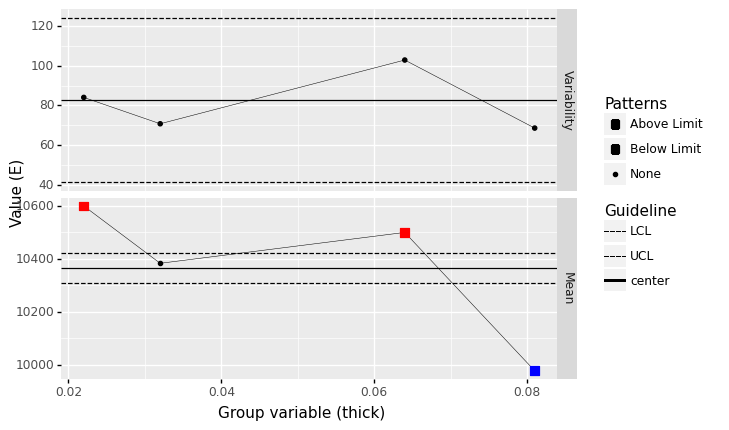

<ggplot: (8769166139043)>

In [3]:
(
    df_stang
    >> gr.pt_xbs(group="thick", var="E")
)

- The variability is under control
- The mean is not under control; in particular the thickest plates have a much lower elasticity

# True Model Setup


In [4]:
from grama.models import make_plate_buckle
md_plate = make_plate_buckle()
md_plate

model: Plate Buckling

  inputs:
    var_det:
      h: [6, 18]
      L: [0.00064, 0.00256]
      t: [0.03, 0.12]
      m: [1, 5]
      w: [6, 18]

    var_rand:
      E: (+0) norm, {'mean': '1.034e+04', 's.d.': '2.587e+02', 'COV': 0.03, 'skew.': 0.0, 'kurt.': 3.0}
      mu: (+0) beta, {'mean': '3.200e-01', 's.d.': '1.000e-02', 'COV': 0.02, 'skew.': -0.13, 'kurt.': 1.79}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0    E   mu  0.371244

  functions:
      f0: ['w', 'h', 'm'] -> ['k_cr']
      limit state: ['k_cr', 't', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']

## Data generation

Want a dataset to have students practice using control charts; deliberately introduce some out-of-control observations in the dataset.


In [5]:
np.random.seed(101)

n_batch = 10
mg_standard = gr.marg_mom("norm", mean=0, sd=1)

# Base properties; mean and sd differences across operators and plate thicknesses
df_base = (
    gr.df_make(
        t=[1/4, 1/8],
        E_base=[1.0e4, 1.2e4],
        COV=[0.03, 0.03],
    )
    >> gr.tf_outer(gr.df_make(
        machine=["A", "B", "C", "D", "E", "F"],
        eff=[0, 0, 0.06, 0, 0, 0],
    ))
    >> gr.tf_mutate(E_mean=DF.E_base * (1 + DF.eff))
)

df_noise = gr.df_make(
    id_measurement=["g", "h", "i", "j", "k", "l"],
    noise_sd=[4e2, 8e2, 4e2, 4e2, 4e2, 4e2],
)

df_data = gr.df_grid()
for i in range(df_base.shape[0]):
    # Initialize model for true material properties
    md_tmp = (
        gr.Model()
        >> gr.cp_marginals(
            E = gr.marg_mom("lognorm", floc=0, mean=df_base.E_mean[i], cov=df_base.COV[i]),
            mu = gr.marg_mom("lognorm", floc=0, mean=0.32, cov=0.03),
        )
        >> gr.cp_copula_independence()
    )

    # "True" material properties
    df_true = (
        md_tmp
        >> gr.ev_sample(n=n_batch, df_det="nom", skip=True)
        >> gr.tf_mutate(t=df_base.t[i], id_machine=df_base.machine[i])
    )

    # Record values
    df_data = (
        df_data
        >> gr.tf_bind_rows(df_true)
    )


# Measured properties
n_total = df_data.shape[0] * df_noise.shape[0]
df_data = (
    df_data
    >> gr.tf_mutate(id_specimen=DF.index)
    >> gr.tf_outer(df_noise)
    >> gr.tf_mutate(z=mg_standard.r(n_total), z2=mg_standard.r(n_total))
    >> gr.tf_mutate(
        E=DF.E + DF.noise_sd * DF.z,
        mu=DF.mu + 0.005 * DF.z2,
    )
    >> gr.tf_drop("z", "noise_sd")
)

## Write data to disk
df_data.to_csv(filename_data, index=False)

## Printout
df_data

Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.


,E,mu,t,id_machine,id_specimen,id_measurement,z2
0,10113.457096,0.319442,0.250,A,0,g,-0.425306
1,9432.148720,0.308230,0.250,A,1,g,-0.531605
2,10468.172283,0.328422,0.250,A,2,g,-0.174609
3,9474.697920,0.333919,0.250,A,3,g,0.376631
4,10010.402837,0.310751,0.250,A,4,g,-0.158085
...,...,...,...,...,...,...,...
715,11935.167126,0.319328,0.125,F,115,l,0.401776
716,11552.946124,0.317546,0.125,F,116,l,-0.910360
717,11985.579932,0.332173,0.125,F,117,l,-1.175355
718,12092.949690,0.317655,0.125,F,118,l,1.779358


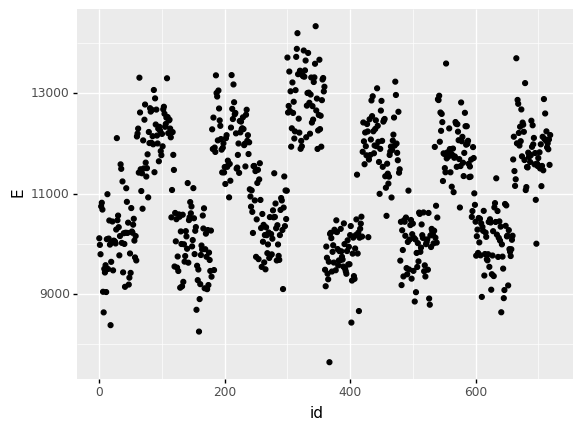

<ggplot: (8769132554632)>

In [6]:
(
    df_data
    >> gr.tf_arrange(DF.id_specimen)
    >> gr.tf_mutate(id=DF.index)
    >> gr.ggplot(gr.aes("id", "E"))
    + gr.geom_point()
)

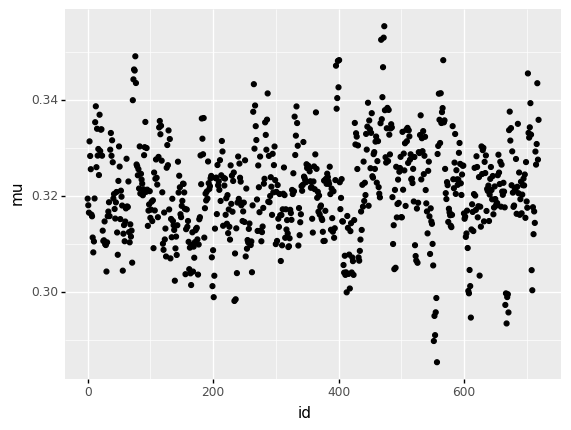

<ggplot: (8769187666941)>

In [7]:
(
    df_data
    >> gr.tf_arrange(DF.id_specimen)
    >> gr.tf_mutate(id=DF.index)
    >> gr.ggplot(gr.aes("id", "mu"))
    + gr.geom_point()
)

In [8]:
(
    df_data
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        E_mean=gr.mean(DF.E),
        E_sd=gr.sd(DF.E),
    )
    >> gr.tf_mutate(E_cov=DF.E_sd/DF.E_mean)
)

,t,E_mean,E_sd,E_cov
0,0.125,12146.587342,700.220316,0.057647
1,0.250,10057.472874,623.598487,0.062003


# Data Analysis


## Real vs Error


In [9]:
df_real = (
    df_data
    >> gr.tf_group_by(DF.t, DF.id_specimen, DF.id_machine)
    >> gr.tf_summarize(
        E=gr.mean(DF.E),
        mu=gr.mean(DF.mu),
    )
    >> gr.tf_ungroup()
    >> gr.tf_arrange(DF.id_machine)
)
df_real

,id_machine,id_specimen,t,E,mu
0,A,10,0.125,12332.355223,0.319730
1,A,4,0.250,10497.188893,0.311414
2,A,5,0.250,10652.735229,0.313597
3,A,6,0.250,10010.764216,0.328221
4,A,7,0.250,10335.259320,0.317475
...,...,...,...,...,...
115,F,112,0.125,12250.337151,0.331432
116,F,111,0.125,12362.581432,0.297405
117,F,110,0.125,11903.101500,0.321495
118,F,108,0.250,10150.122389,0.318976


## Xbar and S charts

### 1/4 Plates


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and wi

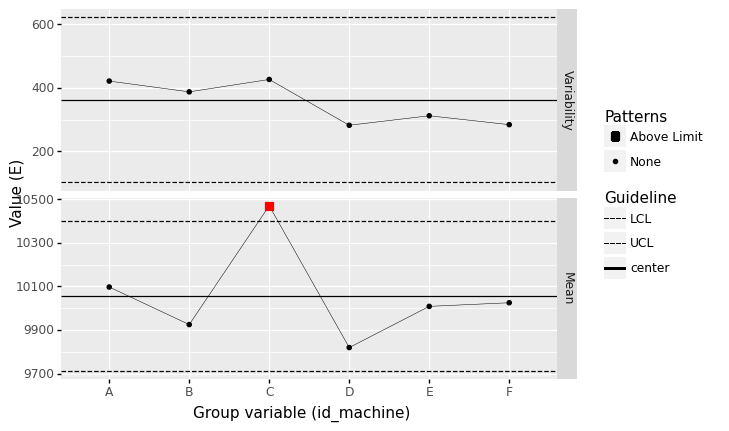

<ggplot: (8769187693912)>

In [10]:
(
    df_real
    >> gr.tf_filter(DF.t == 1/4)
    >> gr.pt_xbs(group="id_machine", var="E")
)

/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and wi

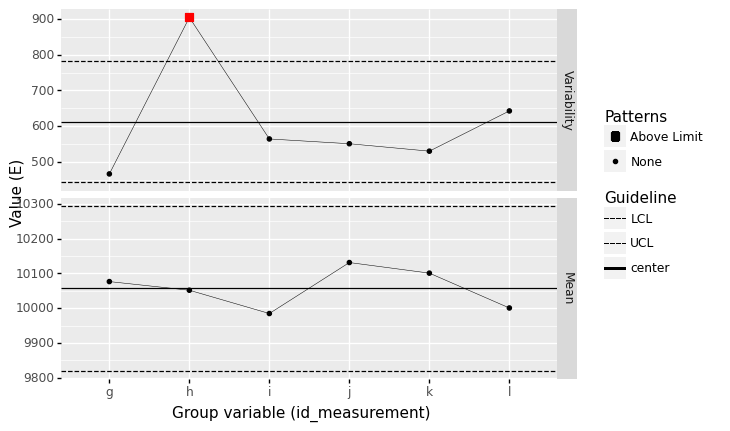

<ggplot: (8769166623549)>

In [11]:
(
    df_data
    >> gr.tf_filter(DF.t == 1/4)
    >> gr.pt_xbs(group="id_measurement", var="E")
)

### 1/8 Plates


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and wi

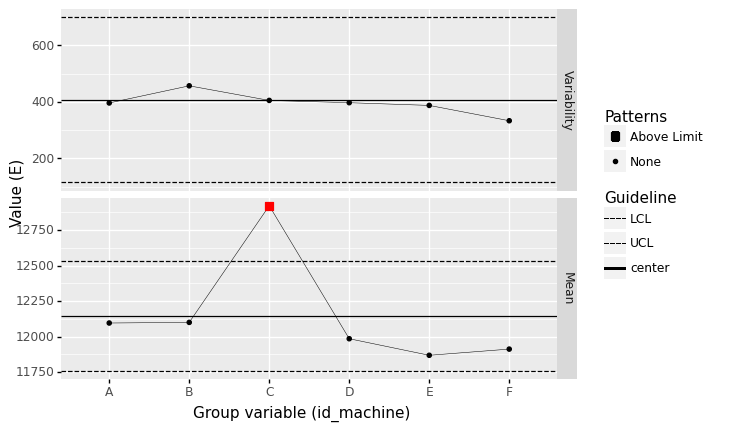

<ggplot: (8769148909933)>

In [12]:
(
    df_real
    >> gr.tf_filter(DF.t == 1/8)
    >> gr.pt_xbs(group="id_machine", var="E")
)

/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/Users/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and wi

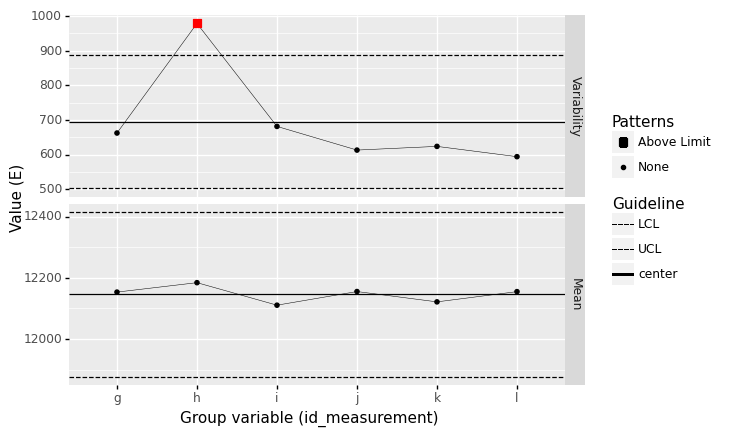

<ggplot: (8769188275637)>

In [13]:
(
    df_data
    >> gr.tf_filter(DF.t == 1/8)
    >> gr.pt_xbs(group="id_measurement", var="E")
)